In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
import warnings
warnings.filterwarnings("ignore")
from itertools import cycle
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans

# Loading The Data: 2014 Boston Marathon Results

In [39]:
marathon = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')

In [40]:
marathon.dtypes

10k           object
name          object
division       int64
25k           object
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
ctz           object
35k           object
overall        int64
pace         float64
state         object
30k           object
5k            object
half          object
20k           object
country       object
city          object
40k           object
dtype: object

# Sampling

In [41]:
marathon = marathon.sample(frac=0.1, random_state = 0)

# Drops: Ordinal & Nominal Features

**Intuition suggested (and some research confirmed) that one-hot-encoded nominal and ordinal features still wouldn't be meaningful inputs to distance-based clustering algorithms (K-Means and Mean-Shift). They could work with similarity-based clustering algorithms (Spectral and Affinity Propagation), but I've chosen the simpler all-numerical case for initial analysis (I'll read more about K-Modes and K-Prototype later).** 

In [42]:
marathon = marathon.drop(['bib','city','country','ctz','division','gender','genderdiv','overall','name','state'], 1)

# Checking Missingness

In [43]:
marathon.head()

,10k,25k,age,official,35k,pace,30k,5k,half,20k,40k
252,42.42,105.28,33,177.10,146.70,6.77,126.02,21.38,89.28,84.78,167.98
18599,50.53,128.45,46,222.25,183.45,8.48,155.68,25.42,107.72,102.10,210.42
13797,47.98,122.43,57,235.00,182.92,8.97,149.88,23.63,102.77,97.53,218.92
6472,43.00,112.60,25,200.45,164.07,7.65,138.08,21.23,93.92,88.80,189.53
17205,56.37,139.18,36,239.85,198.03,9.15,169.98,28.53,118.00,112.07,227.67


# Reordering Columns 

In [44]:
marathon[['10k','25k','age','official','35k','pace','30k','5k','half','20k','40k']] = marathon[['5k','10k','20k','half','25k','30k','35k','40k','age','official','pace']]

# Recasting Objects

In [45]:
columns = marathon[['5k','10k','20k','25k','30k','35k','40k','age','official','pace']]

for column in columns: 
    marathon[column] = pd.to_numeric(marathon[column], errors='coerce')

In [46]:
marathon.dtypes

10k         float64
25k         float64
age         float64
official    float64
35k         float64
pace        float64
30k         float64
5k          float64
half          int64
20k         float64
40k         float64
dtype: object

In [47]:
marathon = marathon.dropna()

In [48]:
marathon.describe()

,10k,25k,age,official,35k,pace,30k,5k,half,20k,40k
count,3166.000000,3166.000000,3166.000000,3166.000000,3166.000000,3166.000000,3166.000000,3166.000000,3166.000000,3166.000000,3166.000000
mean,25.739991,51.750755,105.669460,111.581791,134.062183,164.571924,196.854289,229.093973,42.184144,242.901238,9.272669
std,4.222130,8.761738,19.466659,20.626223,25.980339,33.510329,41.382279,48.685083,11.468917,51.494791,1.964202
min,8.380000,17.650000,37.650000,39.720000,47.670000,58.600000,70.230000,79.830000,18.000000,84.650000,3.230000
25%,22.650000,45.322500,91.497500,96.492500,115.185000,140.302500,166.885000,193.822500,33.000000,205.777500,7.850000
50%,25.230000,50.640000,102.675000,108.375000,129.925000,158.905000,189.240000,219.775000,42.000000,233.500000,8.920000
75%,28.445000,57.050000,116.727500,123.230000,148.830000,184.015000,221.810000,259.080000,50.000000,275.465000,10.520000
max,45.680000,94.450000,211.750000,222.070000,281.850000,376.380000,449.330000,508.350000,81.000000,534.220000,20.380000


# Univariate Distributions

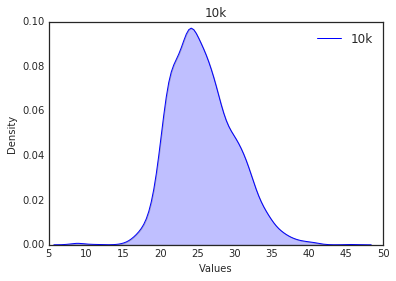

count    3166.000000
mean       25.739991
std         4.222130
min         8.380000
25%        22.650000
50%        25.230000
75%        28.445000
max        45.680000
Name: 10k, dtype: float64


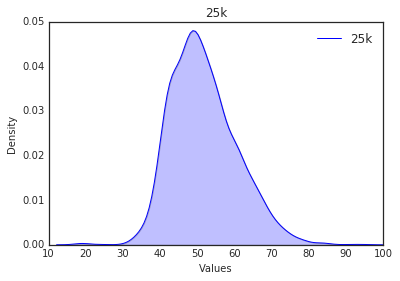

count    3166.000000
mean       51.750755
std         8.761738
min        17.650000
25%        45.322500
50%        50.640000
75%        57.050000
max        94.450000
Name: 25k, dtype: float64


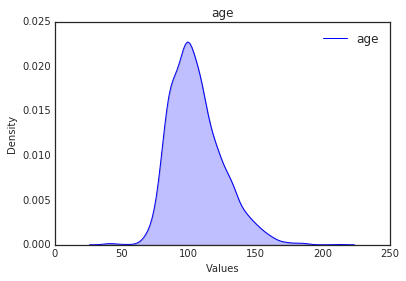

count    3166.000000
mean      105.669460
std        19.466659
min        37.650000
25%        91.497500
50%       102.675000
75%       116.727500
max       211.750000
Name: age, dtype: float64


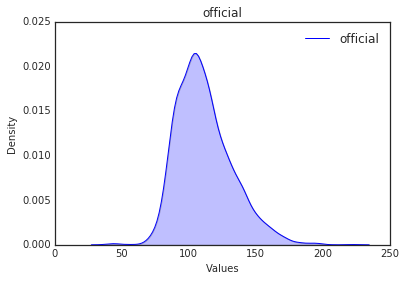

count    3166.000000
mean      111.581791
std        20.626223
min        39.720000
25%        96.492500
50%       108.375000
75%       123.230000
max       222.070000
Name: official, dtype: float64


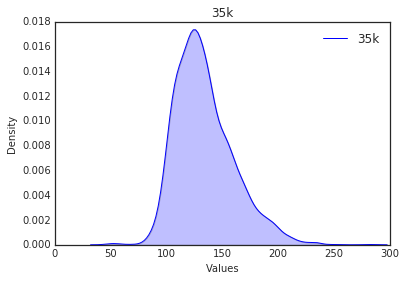

count    3166.000000
mean      134.062183
std        25.980339
min        47.670000
25%       115.185000
50%       129.925000
75%       148.830000
max       281.850000
Name: 35k, dtype: float64


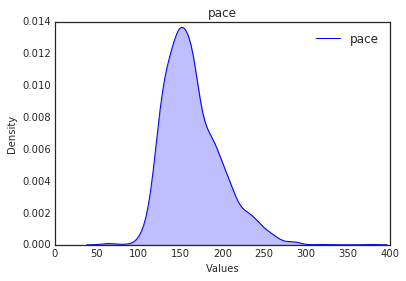

count    3166.000000
mean      164.571924
std        33.510329
min        58.600000
25%       140.302500
50%       158.905000
75%       184.015000
max       376.380000
Name: pace, dtype: float64


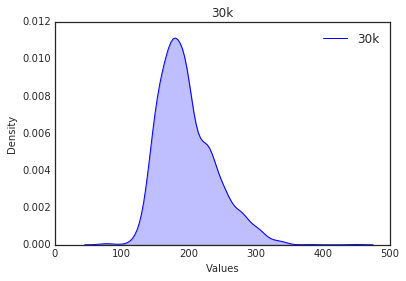

count    3166.000000
mean      196.854289
std        41.382279
min        70.230000
25%       166.885000
50%       189.240000
75%       221.810000
max       449.330000
Name: 30k, dtype: float64


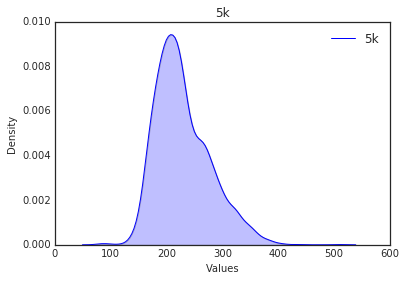

count    3166.000000
mean      229.093973
std        48.685083
min        79.830000
25%       193.822500
50%       219.775000
75%       259.080000
max       508.350000
Name: 5k, dtype: float64


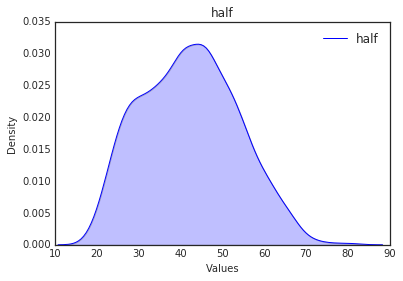

count    3166.000000
mean       42.184144
std        11.468917
min        18.000000
25%        33.000000
50%        42.000000
75%        50.000000
max        81.000000
Name: half, dtype: float64


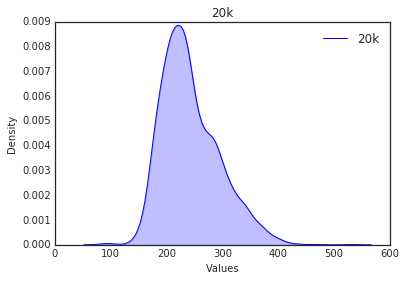

count    3166.000000
mean      242.901238
std        51.494791
min        84.650000
25%       205.777500
50%       233.500000
75%       275.465000
max       534.220000
Name: 20k, dtype: float64


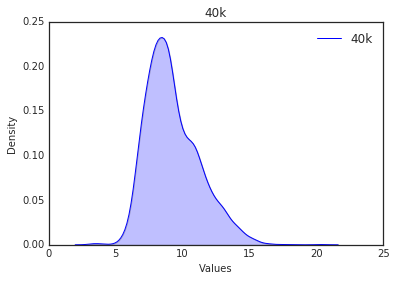

count    3166.000000
mean        9.272669
std         1.964202
min         3.230000
25%         7.850000
50%         8.920000
75%        10.520000
max        20.380000
Name: 40k, dtype: float64


In [49]:
columns_to_plot = marathon.columns
for column in columns_to_plot: 
    sns.kdeplot(marathon[column], shade=True)
    plt.title(column)
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.show()
    print(marathon[column].describe())

# Normalization: Preprocessing

In [50]:
X_normalized = normalize(marathon)
X_normalized_df = pd.DataFrame(normalize(marathon), columns = marathon.columns)

# Principal Components Analysis: Visualization

In [51]:
X_pca = PCA(n_components=2).fit_transform(X_normalized)
X_pca_df = pd.DataFrame(PCA(n_components=2).fit_transform(X_normalized))

# Mean-Shift

## All Features 

Number of Estimated Clusters: 4


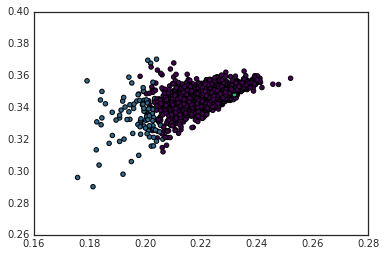

In [52]:
bandwidth = estimate_bandwidth(X_normalized)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X_normalized_df)

ms_labels = ms.labels_
cluster_centers = ms.cluster_centers_
n_clusters_ = len(np.unique(ms_labels))

print("Number of Estimated Clusters: {}".format(n_clusters_))
plt.scatter(X_normalized_df['age'], X_normalized_df['pace'], c=ms_labels, cmap='viridis')
plt.show()

## 2 Principal Components 

Number of Estimated Clusters: 3


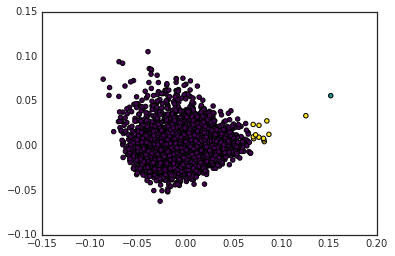

In [53]:
bandwidth2 = estimate_bandwidth(X_pca)
ms2 = MeanShift(bandwidth=bandwidth2, bin_seeding=True).fit(X_pca_df)

ms2_labels = ms2.labels_
cluster_centers2 = ms2.cluster_centers_
n_clusters_2 = len(np.unique(ms2_labels))

print("Number of Estimated Clusters: {}".format(n_clusters_2))
plt.scatter(X_pca_df.iloc[:,0], X_pca_df.iloc[:,1], c=ms2_labels, cmap='viridis')
plt.show()

# K-Means

## All Features

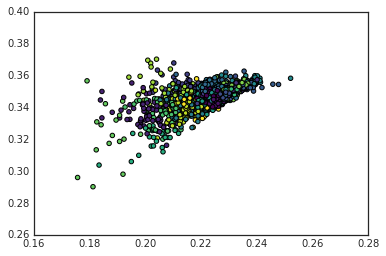

In [54]:
km = KMeans(n_clusters=22, random_state=0).fit(X_normalized_df)

km_labels = km.labels_
plt.scatter(X_normalized_df['age'], X_normalized_df['pace'], c=km_labels, cmap='viridis')
plt.show()

## 2 Principal Components 

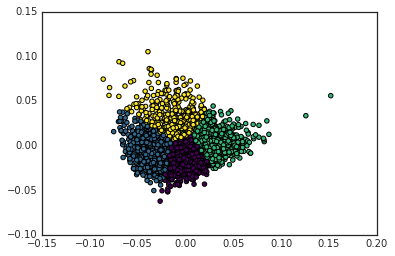

In [55]:
km2 = KMeans(n_clusters=4, random_state=0).fit(X_pca_df)

km2_labels = km2.labels_
plt.scatter(X_pca_df.iloc[:,0], X_pca_df.iloc[:,1], c=km2_labels, cmap='viridis')
plt.show()

# Spectral

## All Features

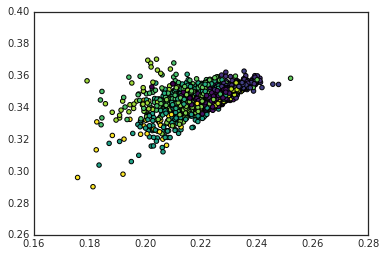

In [56]:
n_clusters=22

sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_normalized_df)

sc_labels = sc.labels_
plt.scatter(X_normalized_df['age'], X_normalized_df['pace'], c=sc_labels, cmap='viridis')
plt.show()

## 2 Principal Components 

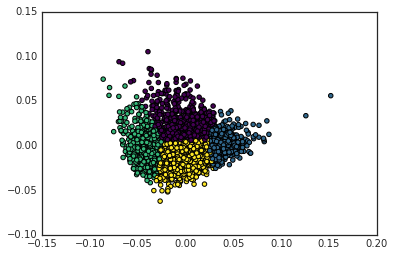

In [57]:
n_clusters2=4

sc2 = SpectralClustering(n_clusters=n_clusters2)
sc2.fit(X_pca_df)

sc2_labels = sc2.labels_
plt.scatter(X_pca_df.iloc[:,0], X_pca_df.iloc[:,1], c=sc2_labels, cmap='viridis')
plt.show()

# Affinity Propagation

## All Features

In [58]:
af = AffinityPropagation().fit(X_normalized_df)
print('Model Fitting Status: Complete.')

cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
af_labels = af.labels_
print('Estimated Number of Clusters: {}'.format(n_clusters_))

Model Fitting Status: Complete.
Estimated Number of Clusters: 83


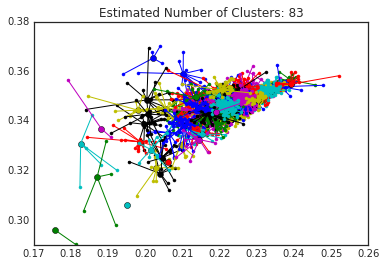

In [59]:
plt.figure()
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for i, color in zip(range(n_clusters_), colors):
    class_members = af_labels == i
    cluster_center = X_normalized[cluster_centers_indices[i]]
    plt.plot(X_normalized[[class_members, 2]], X_normalized[[class_members, 5]], color + '.')
    plt.plot(cluster_center[2],
             cluster_center[5],
             'o',
             markerfacecolor=color,
             markeredgecolor='k')
    for x in X_normalized[class_members]:
        plt.plot([cluster_center[2], x[2]], [cluster_center[5], x[5]], color)

plt.title('Estimated Number of Clusters: {}'.format(n_clusters_))
plt.show()

## 2 Principal Components

In [60]:
af2 = AffinityPropagation().fit(X_pca_df)
print('Model Fitting Status: Complete.')

cluster_centers_indices = af2.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
af2_labels = af2.labels_
print('Estimated Number of Clusters: {}'.format(n_clusters_))

Model Fitting Status: Complete.
Estimated Number of Clusters: 305


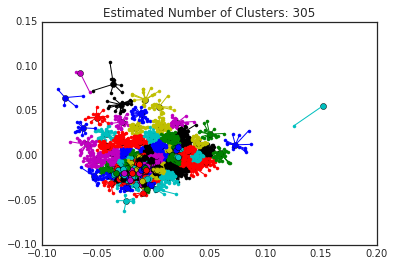

In [61]:
plt.figure()
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for i, color in zip(range(n_clusters_), colors):
    class_members = af2_labels == i
    cluster_center = X_pca[cluster_centers_indices[i]]
    plt.plot(X_pca[class_members, 0], X_pca[class_members, 1], color + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=color,
             markeredgecolor='k')
    for x in X_pca[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], color)

plt.title('Estimated Number of Clusters: {}'.format(n_clusters_))
plt.show()

# Evaluation: Silhouette Coefficients 

In [62]:
ms_silhouette = metrics.silhouette_score(X_normalized_df, ms_labels, metric='euclidean')
km_silhouette = metrics.silhouette_score(X_normalized_df, km_labels, metric='euclidean')
sc_silhouette = metrics.silhouette_score(X_normalized_df, sc_labels, metric='euclidean')
af_silhouette = metrics.silhouette_score(X_normalized, af_labels, metric='euclidean')

In [63]:
print('Mean-Shift Silhouette Coefficient: {:.2}'.format(ms_silhouette))
print('K-Means Silhouette Coefficient: {:.2}'.format(km_silhouette))
print('Spectral Silhouette Coefficient: {:.2}'.format(sc_silhouette))
print('Affinity Propagation Silhouette Coefficient: {:.2}'.format(af_silhouette))

Mean-Shift Silhouette Coefficient: 0.34
K-Means Silhouette Coefficient: 0.25
Spectral Silhouette Coefficient: 0.041
Affinity Propagation Silhouette Coefficient: 0.2


In [64]:
ms_pca_silhouette = metrics.silhouette_score(X_pca_df, ms2_labels, metric='euclidean')
km_pca_silhouette = metrics.silhouette_score(X_pca_df, km2_labels, metric='euclidean')
sc_pca_silhouette = metrics.silhouette_score(X_pca_df, sc2_labels, metric='euclidean')
af_pca_silhouette = metrics.silhouette_score(X_pca, af2_labels, metric='euclidean')

In [65]:
print('PCA Mean-Shift Silhouette Coefficient: {:.2}'.format(ms_pca_silhouette))
print('PCA K-Means Silhouette Coefficient: {:.2}'.format(km_pca_silhouette))
print('PCA Spectral Silhouette Coefficient: {:.2}'.format(sc_pca_silhouette))
print('PCA Affinity Propagation Silhouette Coefficient: {:.2}'.format(af_pca_silhouette))

PCA Mean-Shift Silhouette Coefficient: 0.47
PCA K-Means Silhouette Coefficient: 0.35
PCA Spectral Silhouette Coefficient: 0.33
PCA Affinity Propagation Silhouette Coefficient: 0.22


**NOTE: There is no 'random_state' keyword argument for the Affinity Propagation model, so the estimated number of clusters changes each time I re-run the cells. The Silhouette Coefficients seem to be stable.**

## Task 1: Directing K-Means & Spectral Models to Find More Clusters

### K-Means (All Features): k = 83

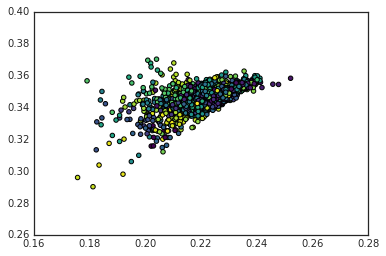

In [66]:
km_more = KMeans(n_clusters=83, random_state=0).fit(X_normalized_df)

km_more_labels = km_more.labels_
plt.scatter(X_normalized_df['age'], X_normalized_df['pace'], c=km_more_labels, cmap='viridis')
plt.show()

### K-Means (2 Principal Components): k = 305

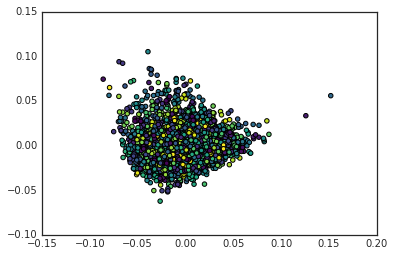

In [67]:
km2_more = KMeans(n_clusters=305, random_state=0).fit(X_pca_df)

km2_more_labels = km2_more.labels_
plt.scatter(X_pca_df.iloc[:,0], X_pca_df.iloc[:,1], c=km2_more_labels, cmap='viridis')
plt.show()

### Spectral (All Features): k = 83

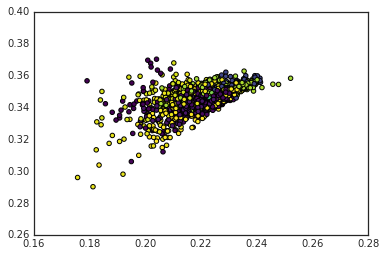

In [68]:
n_clusters_more=83

sc_more = SpectralClustering(n_clusters=n_clusters_more)
sc_more.fit(X_normalized_df)

sc_more_labels = sc_more.labels_
plt.scatter(X_normalized_df['age'], X_normalized_df['pace'], c=sc_more_labels, cmap='viridis')
plt.show()

### Spectral (2 Principal Components): k = 305

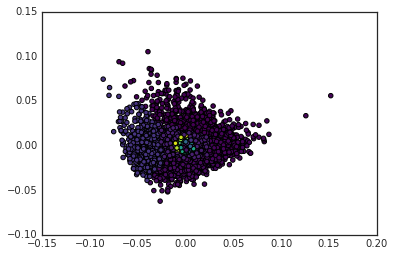

In [69]:
n_clusters2_more = 305

sc2_more = SpectralClustering(n_clusters=n_clusters2_more)
sc2_more.fit(X_pca_df)

sc2_more_labels = sc2_more.labels_
plt.scatter(X_pca_df.iloc[:,0], X_pca_df.iloc[:,1], c=sc2_more_labels, cmap='viridis')
plt.show()

**FINDINGS: I can actually replicate the Affinity Propagation model's results by setting k for the K-Means and Spectral models equal to its estimated number of clusters.**

### Task 2: Changing Mean-Shift Model's Bandwidth

### Mean-Shift (All Features): Quantile = 0.1

Number of Estimated Clusters: 18


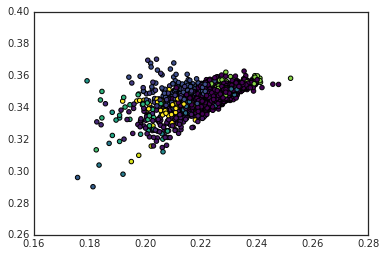

In [71]:
bandwidth_less = estimate_bandwidth(X_normalized, quantile = 0.1)
ms_bl = MeanShift(bandwidth=bandwidth_less, bin_seeding=True).fit(X_normalized_df)

ms_bl_labels = ms_bl.labels_
cluster_centers = ms_bl.cluster_centers_
n_clusters_ = len(np.unique(ms_bl_labels))

print("Number of Estimated Clusters: {}".format(n_clusters_))
plt.scatter(X_normalized_df['age'], X_normalized_df['pace'], c=ms_bl_labels, cmap='viridis')
plt.show()

### Mean-Shift (2 Principal Components): Quantile = 0.1

Number of Estimated Clusters: 6


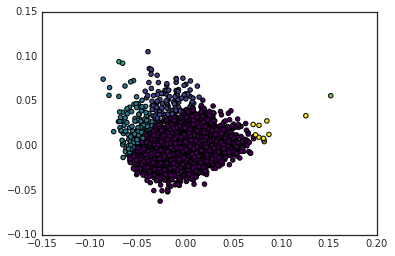

In [73]:
bandwidth2_bl = estimate_bandwidth(X_pca, quantile = 0.1)
ms2_bl = MeanShift(bandwidth=bandwidth2_bl, bin_seeding=True).fit(X_pca_df)

ms2_bl_labels = ms2_bl.labels_
cluster_centers2 = ms2_bl.cluster_centers_
n_clusters_2 = len(np.unique(ms2_bl_labels))

print("Number of Estimated Clusters: {}".format(n_clusters_2))
plt.scatter(X_pca_df.iloc[:,0], X_pca_df.iloc[:,1], c=ms2_bl_labels, cmap='viridis')
plt.show()

### Mean-Shift (All Features): Quantile = 0.5

Number of Estimated Clusters: 3


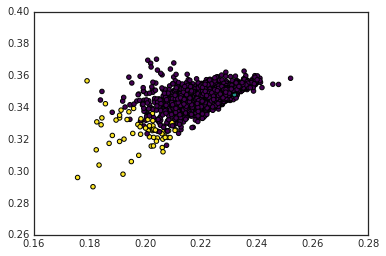

In [72]:
bandwidth_more = estimate_bandwidth(X_normalized, quantile = 0.5)
ms_bm = MeanShift(bandwidth=bandwidth_more, bin_seeding=True).fit(X_normalized_df)

ms_bm_labels = ms_bm.labels_
cluster_centers = ms_bm.cluster_centers_
n_clusters_ = len(np.unique(ms_bm_labels))

print("Number of Estimated Clusters: {}".format(n_clusters_))
plt.scatter(X_normalized_df['age'], X_normalized_df['pace'], c=ms_bm_labels, cmap='viridis')
plt.show()

### Mean-Shift (2 Principal Components): Quantile = 0.5

Number of Estimated Clusters: 2


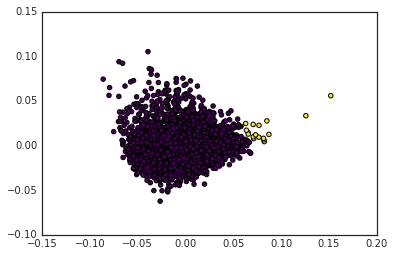

In [74]:
bandwidth2_bm = estimate_bandwidth(X_pca, quantile = 0.5)
ms2_bm = MeanShift(bandwidth=bandwidth2_bm, bin_seeding=True).fit(X_pca_df)

ms2_bm_labels = ms2_bm.labels_
cluster_centers2 = ms2_bm.cluster_centers_
n_clusters_2 = len(np.unique(ms2_bm_labels))

print("Number of Estimated Clusters: {}".format(n_clusters_2))
plt.scatter(X_pca_df.iloc[:,0], X_pca_df.iloc[:,1], c=ms2_bm_labels, cmap='viridis')
plt.show()

**FINDINGS: For the Mean-Shift models, increasing bandwidth via the 'quantile' keyword argument decreases the number of found clusters. Conversely, decreasing bandwidth via the 'quantile' keyword argument increases the number of found clusters.** 

## Task 3: Identifying Features Based on Cluster Resemblance

### All Features

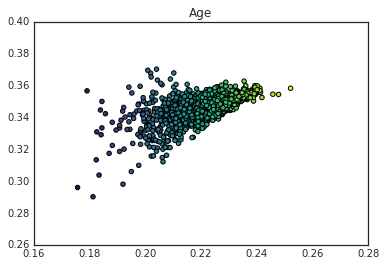

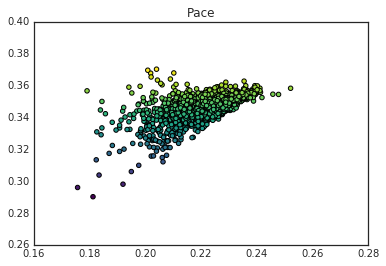

In [79]:
plt.scatter(X_normalized_df['age'], X_normalized_df['pace'], c=X_normalized_df['age'], cmap='viridis')
plt.title('Age')
plt.show()
plt.scatter(X_normalized_df['age'], X_normalized_df['pace'], c=X_normalized_df['pace'], cmap='viridis')
plt.title('Pace')
plt.show()

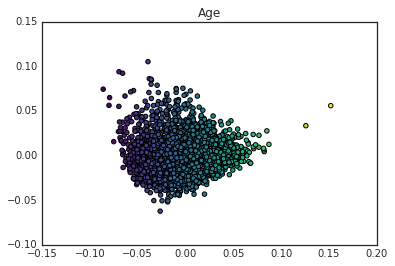

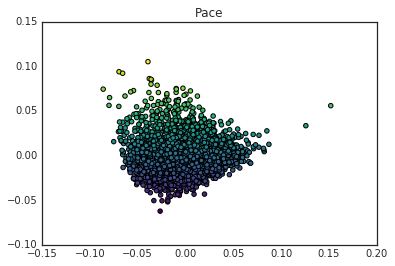

In [80]:
plt.scatter(X_pca_df.iloc[:,0], X_pca_df.iloc[:,1], c=X_pca_df.iloc[:,0], cmap='viridis')
plt.title('Age')
plt.show()
plt.scatter(X_pca_df.iloc[:,0], X_pca_df.iloc[:,1], c=X_pca_df.iloc[:,1], cmap='viridis')
plt.title('Pace')
plt.show()

**NOTE: I couldn't implement this for Affinity Propagation model's clusters, given the color-cycling.**

**FINDINGS: The closest resemblance seems to be between 'Age' and the reduced-bandwidth Mean-Shift model (quantile = 0.1).**